<base target="_blank">

In this article we will explain which steps you need to take to build a quick, reliable classification model with geodata. For our project we've built a model that predicts in which NEW area a pair of wolves will be present in the year to come. To provide some background information: just a few decades ago wolves were nearly extinct in Western Europe. But over the past twenty years the wolf has started to make a comeback. Coming from Poland and other Eastern European countries, the wolf made it's way successfully into Germany and has even reached the western part of The Netherlands. Many wolf pairs have started reproducing and new wolves eventually start looking for their own territory. The wolf population in these countries is slowly climbing.


## Model building steps

The steps for machine learning with Geodata are not so different from building other machine learning models. In short, these are the basic steps to follow for modelbuilding:
<br>
- Collect data 
- Decide on a target variable
- Data preperation
- Model building
- Model evaluation
- Generating insights


### Collecting Data
The dataset we started with contains yearly data (from 2008) for Germany with the name of the area and the wolves, wolf pairs and cubs observed as settled in that area.

Our starting dataframe contains the area of Germany devided in cells of 10 by 10 kilometers. The easiest way to create such a dataframe is using QGIS. The dataframe contains a column called 'GEOMETRY' with the exact coordinates of that cell. In this case it is a POLYGON, which consists of multiple lon/lat points because a cell is an area and not one specific point on the map. 

In [1]:
# Data handling
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
import math

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import mlflow.xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [8]:
# Read in our featureset
df_tot = pd.read_csv('data/featureset.csv', delimiter=";", encoding='utf-8-sig')

# set id as index
df_tot = df_tot.set_index('id')

# Let's look at the data!
df_tot.head()

target  year_registered  Wolf: Distance to closest pack or pair  \
id                                                                              
10kmE403N308     0.0              NaN                              341.583421   
10kmE403N310     0.0              NaN                              325.145169   
10kmE403N311     0.0              NaN                               93.854175   
10kmE404N298     0.0              NaN                              347.940398   
10kmE404N299     0.0              NaN                              324.439091   

              Wolf: Nr of adult wolves in 25 km radius last year  \
id                                                                 
10kmE403N308                                                NaN    
10kmE403N310                                                NaN    
10kmE403N311                                                NaN    
10kmE404N298                                                NaN    
10kmE404N299                                                NaN    

              Wolf: Nr of adult wolves in 50 km radius last year  \
id                                                                 
10kmE403N308                                                NaN    
10kmE403N310                                                NaN    
10kmE403N311                                                NaN    
10kmE404N298                                                NaN    
10kmE404N299                                                NaN    

              Wolf: Nr of adult wolves in 75 km radius last year  \
id                                                                 
10kmE403N308                                                NaN    
10kmE403N310                                                NaN    
10kmE403N311                                                NaN    
10kmE404N298                                                NaN    
10kmE404N299                                                NaN    

              Wolf: Nr of adult wolves in 100 km radius last year  \
id                                                                  
10kmE403N308                                                NaN     
10kmE403N310                                                0.0     
10kmE403N311                                                2.0     
10kmE404N298                                                NaN     
10kmE404N299                                                NaN     

              Wolf: Nr of pups in 25 km radius last year  \
id                                                         
10kmE403N308                                         NaN   
10kmE403N310                                         NaN   
10kmE403N311                                         NaN   
10kmE404N298                                         NaN   
10kmE404N299                                         NaN   

              Wolf: Nr of pups in 50 km radius last year  \
id                                                         
10kmE403N308                                         NaN   
10kmE403N310                                         NaN   
10kmE403N311                                         NaN   
10kmE404N298                                         NaN   
10kmE404N299                                         NaN   

              Wolf: Nr of pups in 75 km radius last year  ...  \
id                                                        ...   
10kmE403N308                                         NaN  ...   
10kmE403N310                                         NaN  ...   
10kmE403N311                                         NaN  ...   
10kmE404N298                                         NaN  ...   
10kmE404N299                                         NaN  ...   

              Landscape: Perc Artificial And Sealed  \
id                                                    
10kmE403N308                               0.000000   
10kmE403N310                               0.166667   
10kmE403N311 

In [10]:
df_tot.shape

(3867, 40)

In [11]:
df_tot.columns

Index(['target', 'year_registered', 'Wolf: Distance to closest pack or pair',
       'Wolf: Nr of adult wolves in 25 km radius last year',
       'Wolf: Nr of adult wolves in 50 km radius last year',
       'Wolf: Nr of adult wolves in 75 km radius last year',
       'Wolf: Nr of adult wolves in 100 km radius last year',
       'Wolf: Nr of pups in 25 km radius last year',
       'Wolf: Nr of pups in 50 km radius last year',
       'Wolf: Nr of pups in 75 km radius last year',
       'Wolf: Nr of pups in 100 km radius last year',
       'Wolf: Nr of yearlings in 25 km radius last year',
       'Wolf: Nr of yearlings in 50 km radius last year',
       'Wolf: Nr of yearlings in 75 km radius last year',
       'Wolf: Nr of yearlings in 100 km radius last year',
       'Wolf: Nr of wolves in 25 km radius last year',
       'Wolf: Nr of wolves in 50 km radius last year',
       'Wolf: Nr of wolves in 75 km radius last year',
       'Wolf: Nr of wolves in 100 km radius last year',
       'An

In [9]:
# Columns we don't want to use in our model
nonfeatcols = ['geometry', 'target', 'StateAreaYear', 'year_registered','Val', 'country', 'Location']
featcols = [i for i in df_tot.columns if i not in nonfeatcols]

# Add our target variable and our feature columns to the dataset
df = df_tot[['target'] + featcols]
df = df.loc[-df[featcols[0]].isnull()]



### Decide on a Target Variable

The target variable in our dataset contains the values 1 (there was a pair/pack of wolves in this area) and 0 (there was no pair/pack of wolves in this area). This means we have a binary target variable and we will be working towards a classification model. 

In [12]:
print(f'Our Target Variable: \n{df.target.value_counts()}')

Our Target Variable: 
0.0    3626
1.0     222
Name: target, dtype: int64


### Data Preperation

To each cell we've added our target variable (1 or 0) that we want to predict. To make predictions on our data we have added 3 types of features to our dataframe:
  - Features with characteristics of that specific area
  - Features with characateristics of surrounding areas
  - Features with historical data of that area

#### Features with characteristics of that specific area
As always, the quality of our predictions depend on the quality and diversity of our features. Together with two biologists (when experts join forces, magic happens) we made a list of possible interesting features to predict wolf presence. Since we relied on open source data, we focused on searching for high quality sources containing as much of the information we were looking for as possible. Luckily for us, the European countries are quite good at joining forces and sharing data. We could find data on roads and railways, on types of land, on animal occurences and on population distributions.

For each of these sources, we downloaded the data, used the geopandas functionality to merge data based on the "geometry" and thus created an overview of characteristics per area (record).

#### Features with characteristics of surrounding areas or historical data of that area
When data is stored in a geopandas dataframe, it's relatively easy to add information of surrounding areas to each area. We calculated the number of wolves that were the year before in a range of 25, 50, 100 or 200 kilometer from a specific cell. And we calculated the distance for each cell to the closest cell that has a pack of pair of wolves in it. 

#### Adding latitude and longitude to your machine learning datasets

Even though it is possible to add the "geometry" information like latitude and longitude to your features, we have decided to create variables that are based on latitude and longitude. Like with a lot of other types of information, if there are a lot of (almost) unique values, you'll probably add more predictive power by transforming these values into a derived variable adding some common sense and thus information that might otherwise stay invisible to the model. This is the same principle as we apply when we decide to transform data of birth into age categories for instance.


### Exploratory Data Analysis

Before we immediately start building a model, it's good to first get a better understanding of the data we have in our dataset. 


#### Correlation Matrix
We start of by creating a correlation matrix. This gives us some basic insights on the relationship between variables.

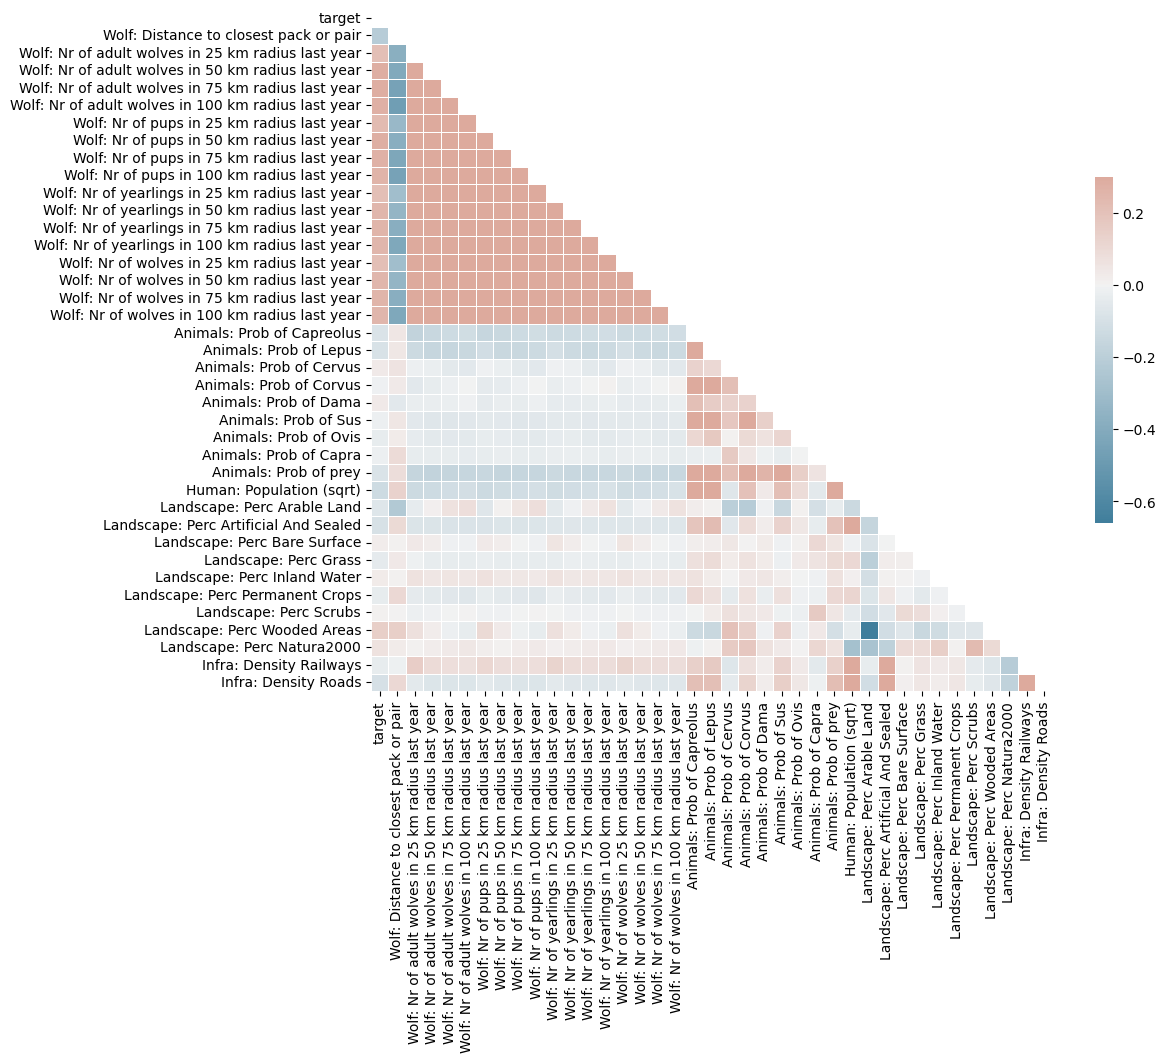

In [14]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#### Variable distribution

Another good check is to look if the distributions of features differ between areas with or without target value. Boxplots are a useful method for this because they standardize the distributions on a five metrics summary (“_minimum_ ”, _first quartile (Q1)_, _median_, _third quartile (Q3)_ and _“maximum”_) and give useful insights into outliers - i.e. values that are very different than the rest of the distribution. The 'box' contains the middle 50% of all the datapoints in your distribution, and everything between the upper and bottom 'whiskers' contains 99% of the datapoints. All datapoints above and under the whiskers - the small dots - are considered outliers and fall far outside of the distribution.

For example, if we look at the *Wolf: Distance to closest pack or pair* variable, we can see that areas without wolf pairs are often further from other wolves than areas with wolf pairs. This _could_ be an indicator for our model. 

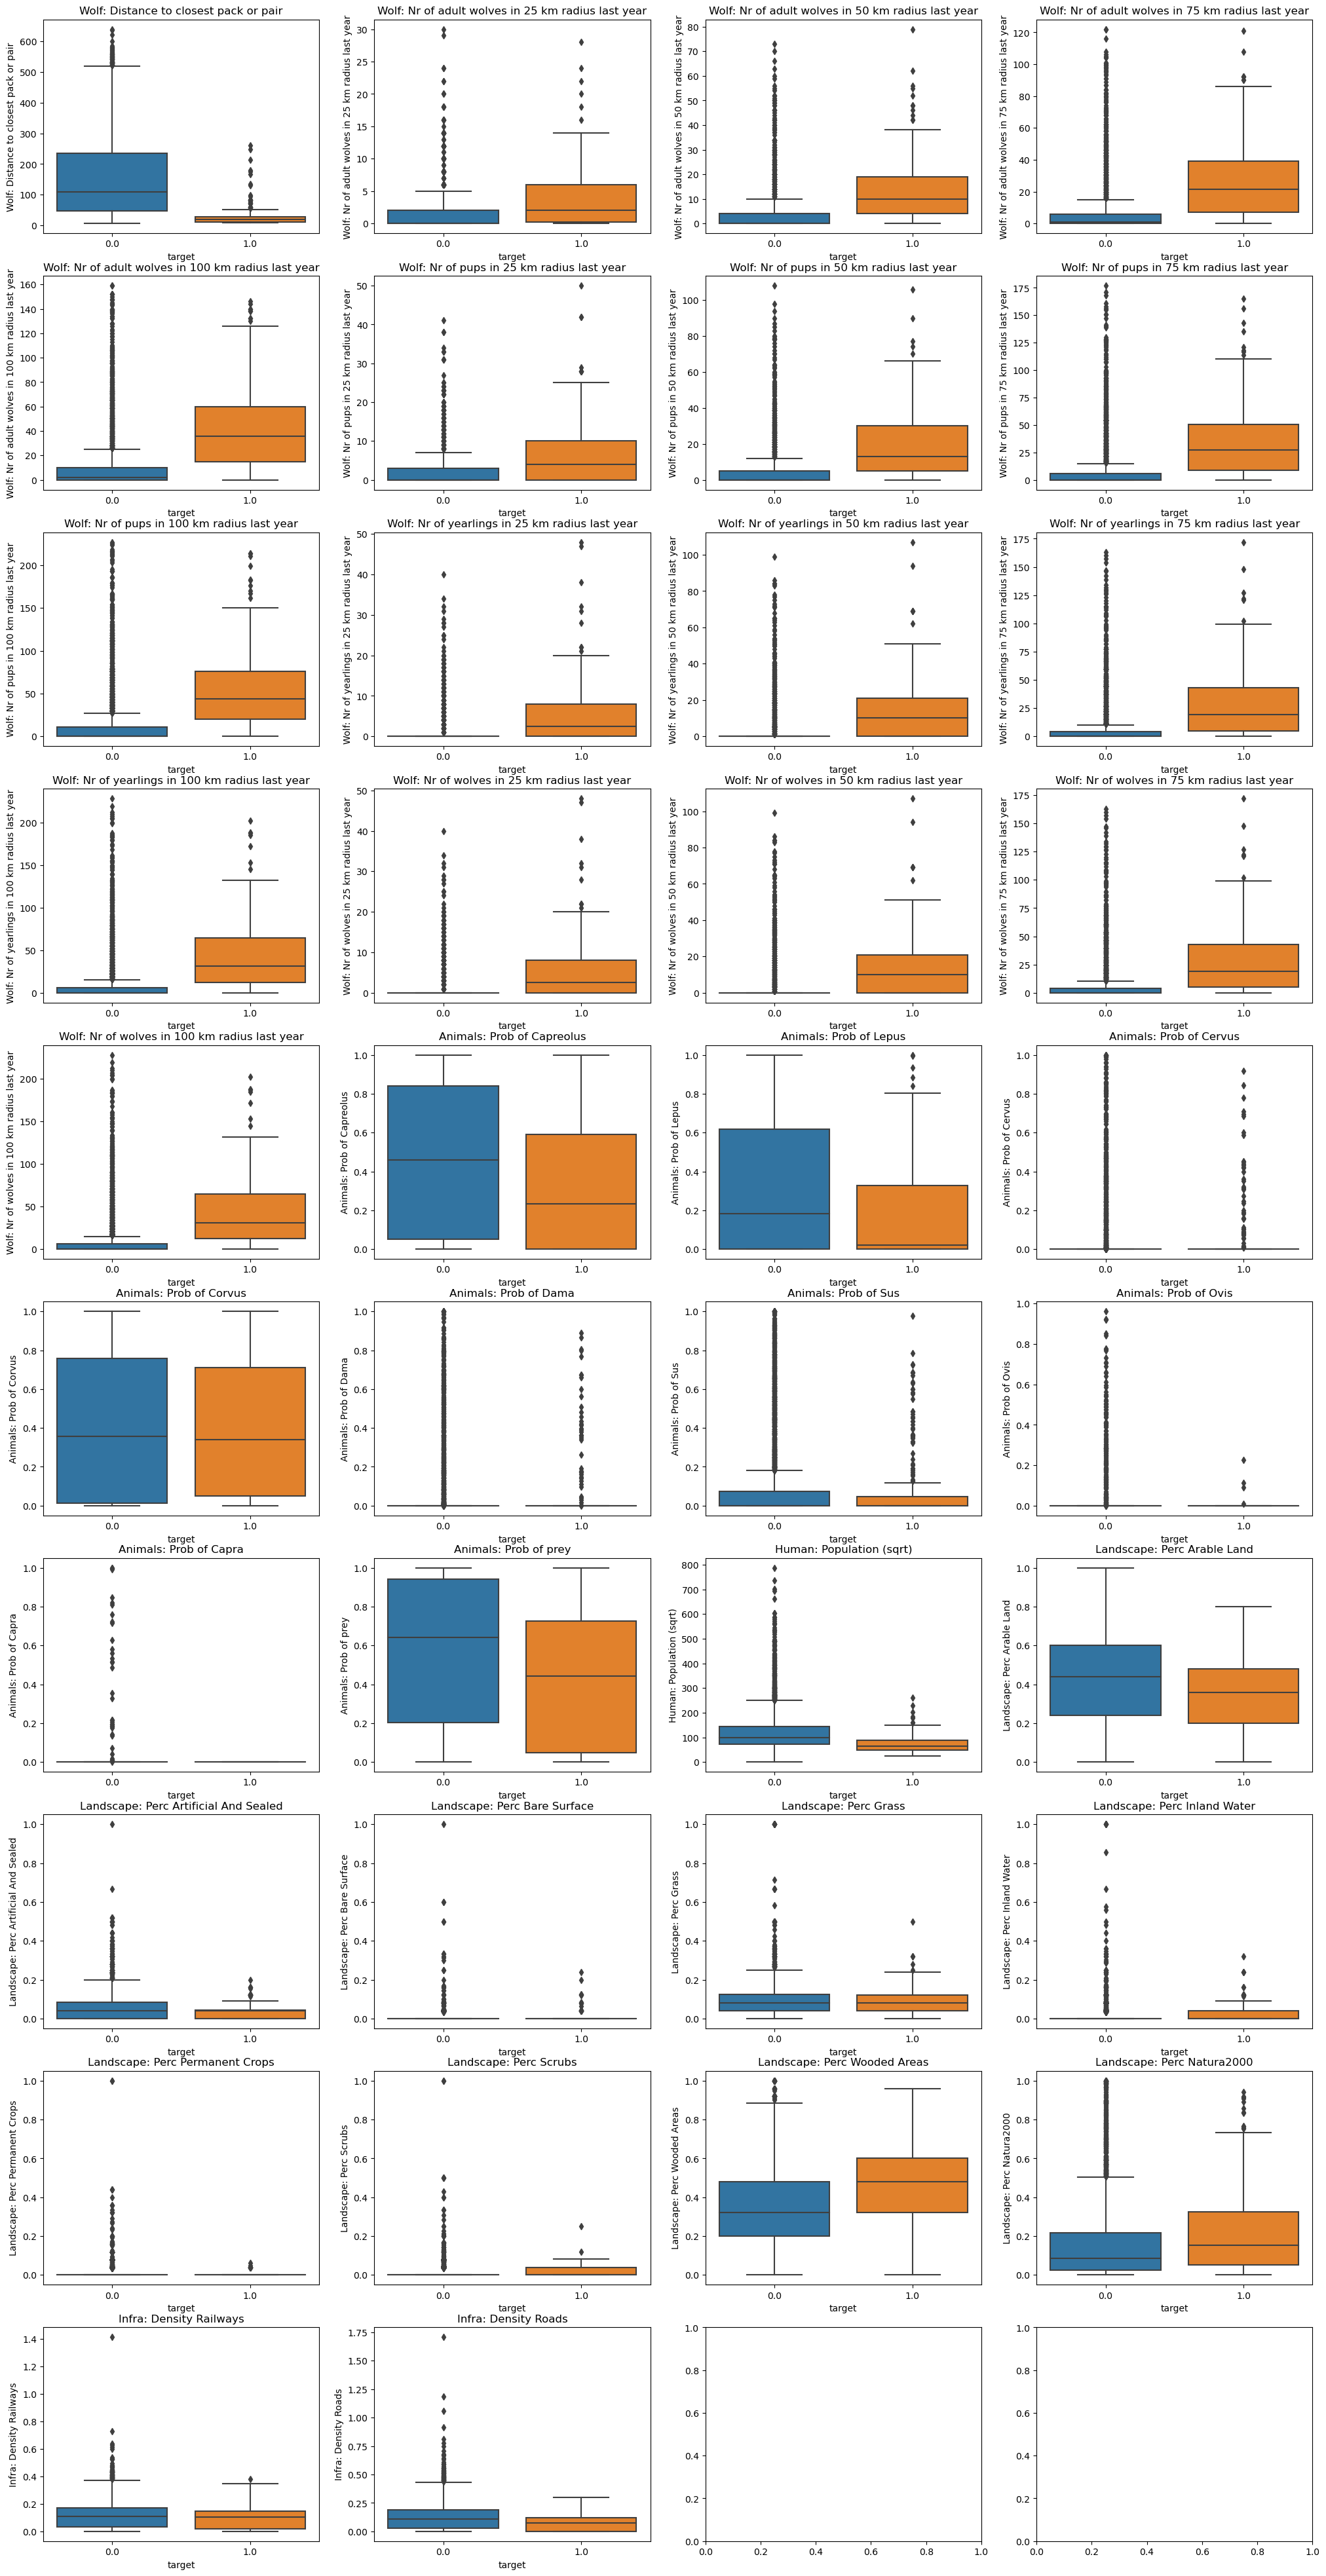

In [15]:
nrows = math.ceil(len(featcols)/4)
dims = (nrows, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, nrows*5))
axis_i, axis_j = 0, 0
for col in featcols:
  sns.boxplot(x=df.target, y=df[col], ax=axes[axis_i, axis_j]).set_title(str(col))
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0


### Model Building

#### Create trainset and testset
The steps for model building on geodata are the same as for other machine learning models. We start by dividing our dataset into a trainset and a testset. Depending on the size of your dataset, the trainset should consist of 70% - 90% of your known data. In our case, we decided to train on 75% of the cases. This leaves us with enough cases to do an accurate evaluation. 

In [16]:
# Define the target vector y
y = df['target']  

# Creating a dataset without the DV:
X = df.drop(columns = ['target'])

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1121218)

In [17]:
print(f"There are {X_train.shape[0]} records in the training set and {X_test.shape[0]} records in the test set.")

There are 2886 records in the training set and 962 records in the test set.


#### Train model

Now that we have a train- and testset, the model can be initiated. We use the XgBoost Classifier, which is considered one of the best performing algorithms and is used in a wide variety of cases. It also has it's drawbacks, especially on interpretability. We dive deeper in that topic in our next blog, where we show how to use SHAP to understand/unbox your xgboost model.

There are lots of parameters to optimize within the XgBoost algorithm. For now we keep it simple and only state that we want to optimize on 'logloss', meaning we try to optimize the model based on log likelihood. It is possible to optimize with more parameters, but the XgBoost Classifier is by default already a good algorithm.

After the model is initiated we can fit it on our traindata.

In [18]:
# Meta instantiates the XGBClassifier, since we are dealing with a classification task:
xgb_cl = xgb.XGBClassifier(eval_metric='logloss', seed=7) 

# Fit the model on our train features (X_train) and our target vector (y_train) 
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

### Model Evaluation

Great, we have trained the model on the traindata. Now we need to evaluate how our model performs on data it hasn't seen before. We use the testset for this.

#### Accuracy
In the classification report we can see a lot of metrics. One metric often used for validating predictions is accuracy. In our case the accuracy is 94%, meaning we have predict 94% of the cases correct. This sounds like a great result, but it's not necessarily good. Most areas have a target value of 0. If our model would only predict 0's it would still have a pretty good accuracy but that does not mean the model performs as it should. 

#### Area Under the Curve (AUC) / ROC Curve
A better evaluation metric is the AUC. The AUC looks at the true positive rate (i.e. the probability that a true value is predicted as a true value) and the false positive rate (i.e. the probability that a true value is predicted as a negative value). In our case the AUC is .90 which normally considered is a good score.

#### What to do when you have bad predictability?
Parameter optimization in your algorithm can help predictability a little bit, but the best way to improve predictability is to feed your model more information. You can do this by adding more data to your model or by engineering your input data in such a way that you extract more information from your current dataset. 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       941
           1       0.16      0.43      0.23        21

    accuracy                           0.94       962
   macro avg       0.57      0.69      0.60       962
weighted avg       0.97      0.94      0.95       962

[[894  12]
 [ 47   9]]


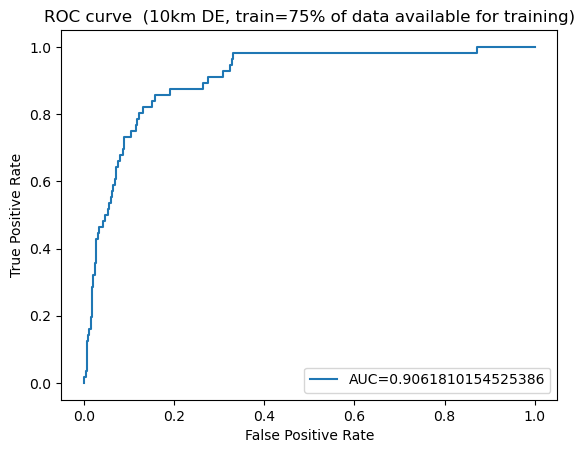

In [19]:
# Make predictions based on testset
pred = xgb_cl.predict(X_test)

# Classification report
print(classification_report(pred,y_test))

# cofnfusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred))

# Create an ROC curve
y_pred_proba = xgb_cl.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC curve  (10km DE, train=75% of data available for training)')
plt.show()

## Recap

Building a Machine Learning model on Geodata follows the same steps as building a model on 'regular' data. Feature engineering is a very important step. You can add features based on geographical characteristics or even just add the longitude and lattitude that is inside your dataset. After data preperation we create a train- and testset to train and evaluate our model. 